# Compare Tranformer Embeddings with RDKit Morgan Fingerprints

## Setup

In [17]:
import random
from typing import List, Union, Literal

from transformers import AutoTokenizer, AutoModel
import torch
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import pandas as pd

import protac_degradation_predictor as pdp

In [2]:
df = protac_df = pdp.load_curated_dataset()
df.head()

,Compound ID,Uniprot,Smiles,E3 Ligase,InChI,InChI Key,Molecular Weight,Heavy Atom Count,Ring Count,Rotatable Bond Count,...,Name,Assay (DC50/Dmax),Exact Mass,XLogP3,Target (Parsed),POI Sequence,E3 Ligase Uniprot,E3 Ligase Sequence,Cell Line Identifier,Active - OR
0,1,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C73H88ClF3N10O10S4/c1-47(49-13-15-51(...,SXPDUCVNMGMWBJ-FMZBIETASA-N,1486.282,101,10,24,...,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,NaN
1,2,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C74H90ClF3N10O10S4/c1-48(50-13-15-52(...,HQKUMELJMUNTTF-NMKDNUEVSA-N,1500.309,102,10,25,...,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,NaN
2,3,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C75H92ClF3N10O10S4/c1-49(51-16-18-53(...,ATQCEJKUPSBDMA-QARNUTPLSA-N,1514.336,103,10,26,...,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,NaN
3,4,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C76H94ClF3N10O10S4/c1-50(52-17-19-54(...,FNKQAGMHNFFSEI-DTTPTBRMSA-N,1528.363,104,10,27,...,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,NaN
4,5,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C77H96ClF3N10O10S4/c1-51(53-18-20-55(...,PXVFFBGSTYQHRO-REQIQPEASA-N,1542.390,105,10,28,...,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,True


In [3]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ailab-bio/PROTAC-Splitter-Encoder")
model = AutoModel.from_pretrained("ailab-bio/PROTAC-Splitter-Encoder")

## Generate SMILES Embeddings

In [26]:
# Function to encode a list of SMILES strings
def run_model_on_smiles(
        smiles_list: List[str],
        tokenizer: AutoTokenizer,
        model: AutoModel,
        batch_size: int = 64,
        device: Union[int, str] = 'cpu',
) -> torch.Tensor:
    """ Encode a list of SMILES strings into embeddings using a pre-trained model.
    
    Args:
        smiles_list (List[str]): List of SMILES strings to encode.
        tokenizer (AutoTokenizer): Tokenizer for the model.
        model (AutoModel): Pre-trained model to use for encoding.
        batch_size (int): Batch size for encoding.
        device (Union[int, str]): Device to run the model on ('cpu' or 'cuda').
        
    Returns:
        torch.Tensor: Tensor of shape (num_smiles, embedding_dim) containing the embeddings.
    """
    model = model.to(device)
    model_inputs = []
    embeddings = []
    for i in range(0, len(smiles_list), batch_size):
        batch = smiles_list[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings.append(outputs)
            model_inputs.append(inputs)
    return model_inputs, embeddings

def encode_smiles(
        smiles_list: List[str],
        tokenizer: AutoTokenizer,
        model: AutoModel,
        batch_size: int = 64,
        device: Union[int, str] = 'cpu',
        pooling: Literal['cls', 'mean', 'sum', 'max', 'mean_sqrt_len'] = 'mean',
) -> torch.Tensor:
    """ Encode a list of SMILES strings into embeddings using a pre-trained model.
    
    Args:
        smiles_list (List[str]): List of SMILES strings to encode.
        tokenizer (AutoTokenizer): Tokenizer for the model.
        model (AutoModel): Pre-trained model to use for encoding.
        batch_size (int): Batch size for encoding.
        device (Union[int, str]): Device to run the model on ('cpu' or 'cuda').
        pooling (Literal['cls', 'mean', 'sum', 'max', 'mean_sqrt_len']): Pooling method to use for pooling the embeddings along the sequence length dimension.
        
    Returns:
        torch.Tensor: Tensor of shape (num_smiles, embedding_dim) containing the embeddings.
    """
    model = model.to(device)
    embeddings = []
    for i in range(0, len(smiles_list), batch_size):
        batch = smiles_list[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            if pooling == 'cls':
                # Use the [CLS] token embedding as the representation
                batch_embeds = outputs.last_hidden_state[:, 0, :].cpu()
            elif pooling == 'mean':
                # Pool the embeddings by averaging
                batch_embeds = outputs.last_hidden_state.mean(dim=1).cpu()
            elif pooling == 'sum':
                # Pool the embeddings by summing
                batch_embeds = outputs.last_hidden_state.sum(dim=1).cpu()
            elif pooling == 'max':
                # Pool the embeddings by taking the max
                batch_embeds = outputs.last_hidden_state.max(dim=1).values.cpu()
            elif pooling == 'mean_sqrt_len':
                # Pool the embeddings by averaging and scaling by the square root of the sequence length
                seq_lengths = inputs['input_ids'].ne(tokenizer.pad_token_id).sum(dim=1, keepdim=True).float()
                batch_embeds = (outputs.last_hidden_state.sum(dim=1) / seq_lengths.sqrt()).cpu()
            else:
                raise ValueError(f"Unsupported pooling method: {pooling}")
            embeddings.append(batch_embeds)
    return torch.cat(embeddings, dim=0)

# Encode the "Smiles" column
smiles_list = df["Smiles"].unique().tolist()

# Randomly select N unique SMILES strings
random.seed(42)  # For reproducibility
N = 20
smiles_list = random.sample(smiles_list, N)

device = "cuda" if torch.cuda.is_available() else "cpu"
smiles_embeddings = encode_smiles(
    smiles_list,
    tokenizer,
    model,
    device=device,
    pooling='mean_sqrt_len',
)

# smiles_embeddings is a torch.Tensor of shape (num_rows, embedding_dim)
print(smiles_embeddings.shape)

torch.Size([20, 768])


In [ ]:
morgan_generator = AllChem.GetMorganGenerator(radius=6, fpSize=512, includeChirality=True, useBondTypes=True)

# Compute Morgan fingerprints for each SMILES
fps = []
for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        fp = morgan_generator.GetFingerprint(mol)
        fps.append(fp)
    else:
        fps.append(None)

## Compute Pairwise Distance Matrices

In [ ]:
def compute_fingerprint_similarity(fps: List[DataStructs.cDataStructs.ExplicitBitVect]) -> np.ndarray:
    """Compute pairwise Tanimoto similarity matrix for fingerprints.
    
    Args:
        fps (List[rdkit.DataStructs.cDataStructs.ExplicitBitVect]): List of fingerprints to compute similarities for.
    """
    # Use BulkTanimotoSimilarity for efficiency
    n = len(fps)
    fp_sim = np.zeros((n, n))
    for i in range(n):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps)
        fp_sim[i, :] = sims
    return fp_sim

# Compute pairwise Tanimoto similarity matrix for Morgan fingerprints
fp_sim = compute_fingerprint_similarity(fps)

# Compute pairwise cosine similarity matrix for embeddings
emb = smiles_embeddings
if isinstance(emb, torch.Tensor):
    emb = emb.cpu().numpy()

# Get the cosine similarity matrix
emb_sim = cosine_similarity(emb)

Compute the Pearson correlation distance matrix for the embeddings and Morgan fingerprints: intuitively, they should be similar, but not "too much", as the embeddings should capture more semantic information about the SMILES strings.

In [15]:
# Flatten the upper triangle of the matrices, excluding the diagonal
mask = np.triu_indices_from(fp_sim, k=1)
fp_sim_flat = fp_sim[mask]
emb_sim_flat = emb_sim[mask]

# Compute Pearson and Spearman correlation
pearson_corr, _ = pearsonr(fp_sim_flat, emb_sim_flat)
spearman_corr, _ = spearmanr(fp_sim_flat, emb_sim_flat)

print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}")

Pearson correlation: 0.172
Spearman correlation: 0.069


## Plot the Distance Matrices

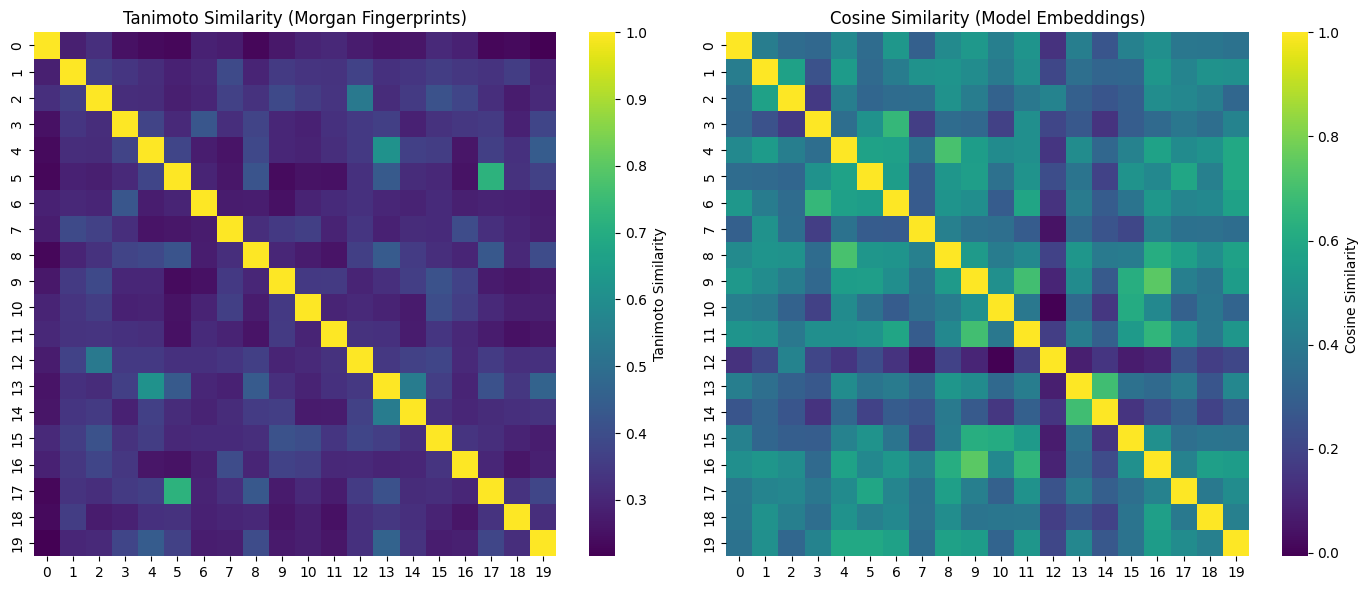

In [16]:
# Plot heatmaps
annot = True if N <= 10 else False
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(fp_sim, ax=axes[0], cmap="viridis", annot=annot, fmt=".2f", cbar_kws={"label": "Tanimoto Similarity"})
axes[0].set_title("Tanimoto Similarity (Morgan Fingerprints)")
sns.heatmap(emb_sim, ax=axes[1], cmap="viridis", annot=annot, fmt=".2f", cbar_kws={"label": "Cosine Similarity"})
axes[1].set_title("Cosine Similarity (Model Embeddings)")
plt.tight_layout()
plt.show()

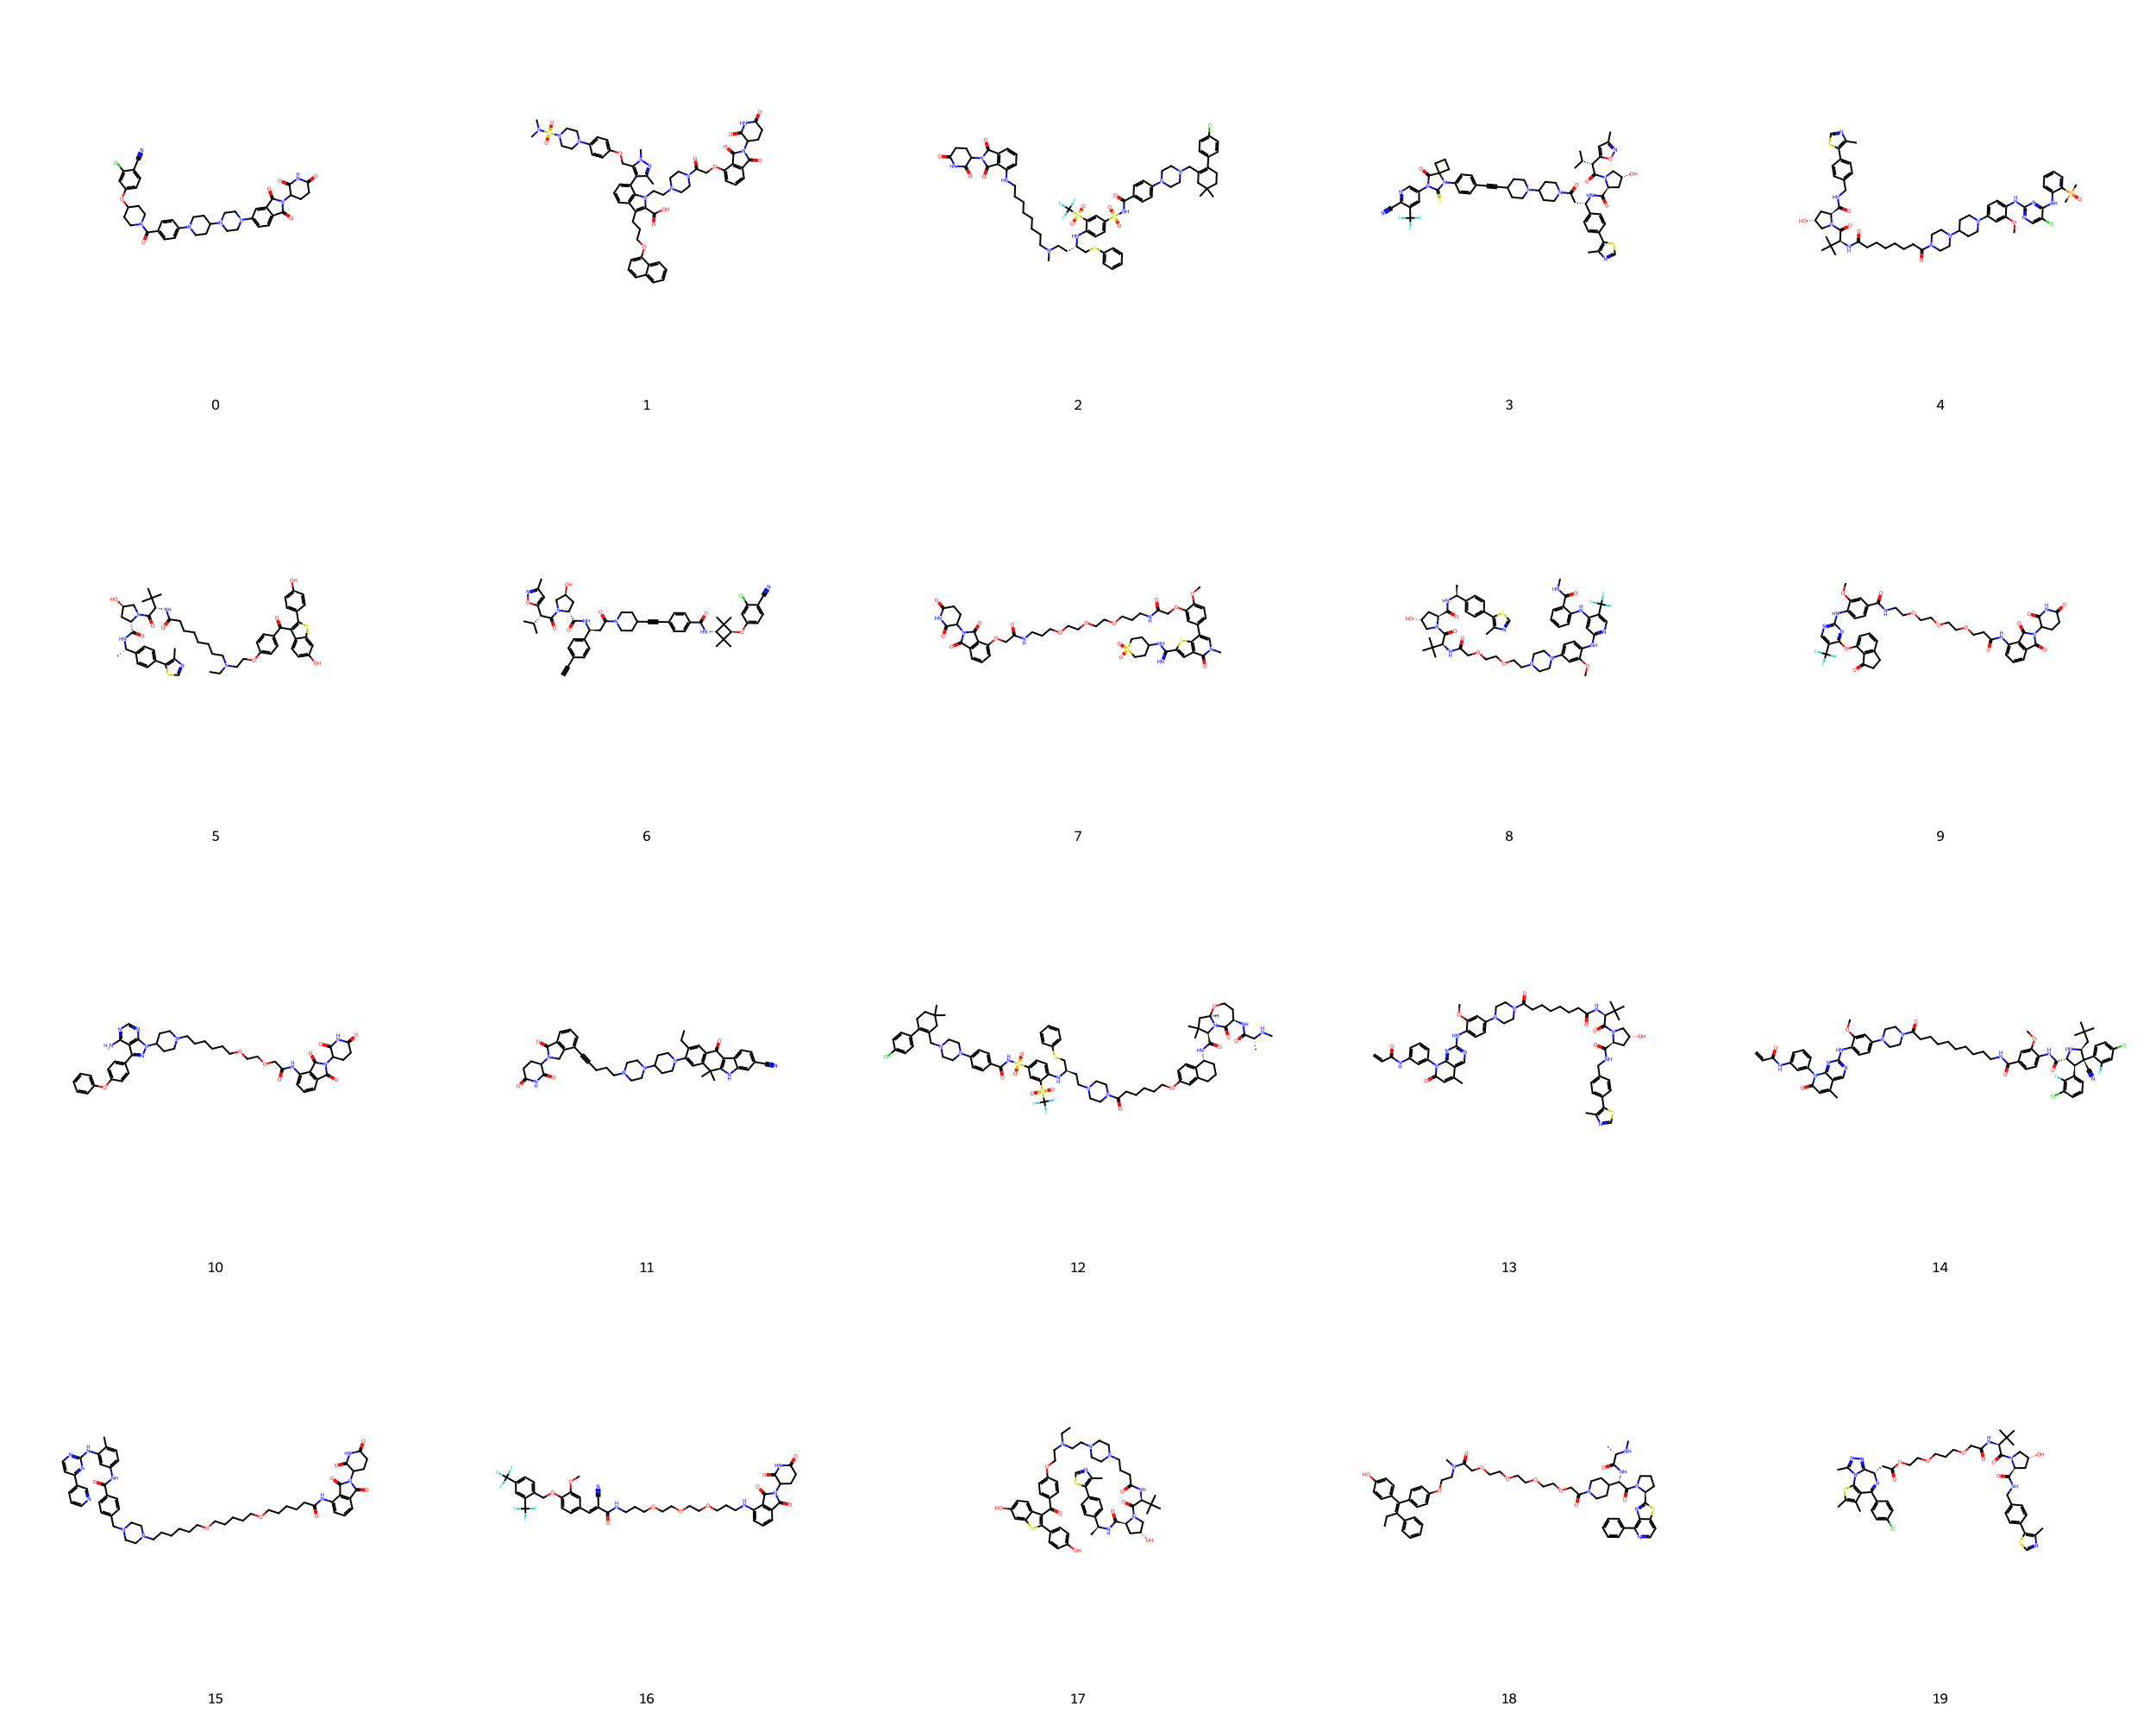

In [9]:
display(Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in smiles_list], molsPerRow=5, subImgSize=(500, 500), legends=[str(i) for i in range(len(smiles_list))]))

Modify a few atoms in a SMILES string to see how the embeddings and fingerprints change.

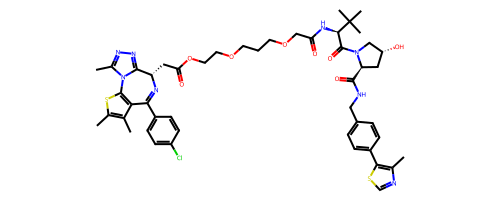

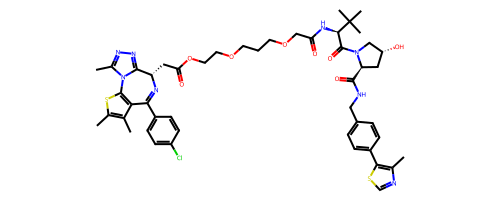

Original SMILES: Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)COCCCOCCOC(=O)C[C@@H]2N=C(c3ccc(Cl)cc3)c3c(sc(C)c3C)-n3c(C)nnc32)C(C)(C)C)cc1
Modified SMILES: Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)COCCCOCCOC(=O)C[C@@H]2N=C(c3ccc(Cl)cc3)c3c(sc(C)c3C)-n3c(C)nnc32)C(C)(C)C)cc1
Original embedding shape: torch.Size([1, 768])
Modified embedding shape: torch.Size([1, 768])
Tanimoto similarity between original and modified SMILES: 1.0000
Cosine similarity between original and modified SMILES: 1.0000


[18:34:50] DEPRECATION WARNING: please use MorganGenerator
[18:34:50] DEPRECATION WARNING: please use MorganGenerator


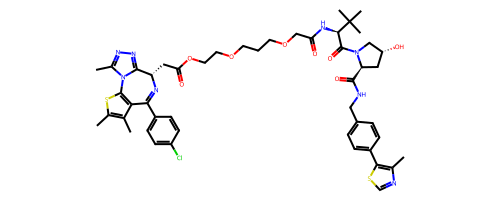

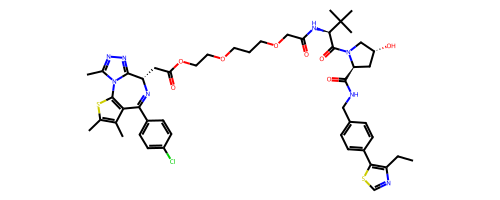

Original SMILES: Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)COCCCOCCOC(=O)C[C@@H]2N=C(c3ccc(Cl)cc3)c3c(sc(C)c3C)-n3c(C)nnc32)C(C)(C)C)cc1
Modified SMILES: CCc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)COCCCOCCOC(=O)C[C@@H]2N=C(c3ccc(Cl)cc3)c3c(sc(C)c3C)-n3c(C)nnc32)C(C)(C)C)cc1
Original embedding shape: torch.Size([1, 768])
Modified embedding shape: torch.Size([1, 768])
Tanimoto similarity between original and modified SMILES: 0.8973
Cosine similarity between original and modified SMILES: 0.9936


[18:34:50] DEPRECATION WARNING: please use MorganGenerator
[18:34:50] DEPRECATION WARNING: please use MorganGenerator


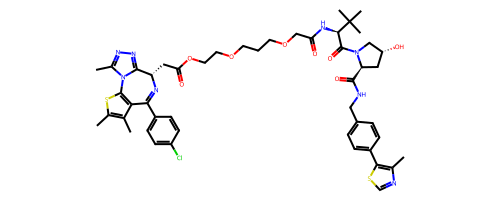

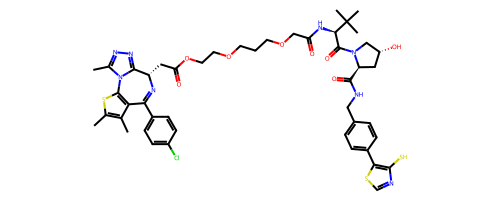

Original SMILES: Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)COCCCOCCOC(=O)C[C@@H]2N=C(c3ccc(Cl)cc3)c3c(sc(C)c3C)-n3c(C)nnc32)C(C)(C)C)cc1
Modified SMILES: Sc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)COCCCOCCOC(=O)C[C@@H]2N=C(c3ccc(Cl)cc3)c3c(sc(C)c3C)-n3c(C)nnc32)C(C)(C)C)cc1
Original embedding shape: torch.Size([1, 768])
Modified embedding shape: torch.Size([1, 768])
Tanimoto similarity between original and modified SMILES: 0.9018
Cosine similarity between original and modified SMILES: 0.9858


[18:34:50] DEPRECATION WARNING: please use MorganGenerator
[18:34:50] DEPRECATION WARNING: please use MorganGenerator


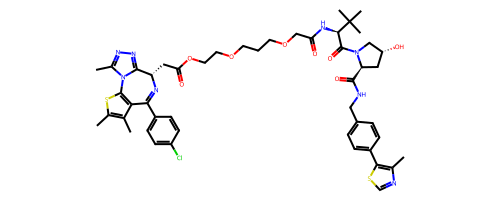

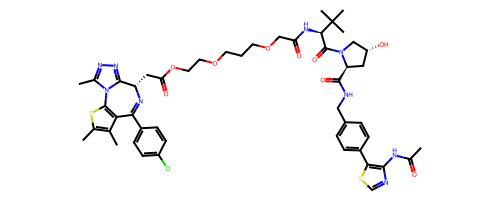

Original SMILES: Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)COCCCOCCOC(=O)C[C@@H]2N=C(c3ccc(Cl)cc3)c3c(sc(C)c3C)-n3c(C)nnc32)C(C)(C)C)cc1
Modified SMILES: CC(=O)Nc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)COCCCOCCOC(=O)C[C@@H]2N=C(c3ccc(Cl)cc3)c3c(sc(C)c3C)-n3c(C)nnc32)C(C)(C)C)cc1
Original embedding shape: torch.Size([1, 768])
Modified embedding shape: torch.Size([1, 768])
Tanimoto similarity between original and modified SMILES: 0.8816
Cosine similarity between original and modified SMILES: 0.9226


[18:34:50] DEPRECATION WARNING: please use MorganGenerator
[18:34:50] DEPRECATION WARNING: please use MorganGenerator


In [12]:
for modification in ["C", "CC", "S", "CC(=O)N"]:
    s = smiles_list[-1]
    s_modified = s.replace("C", modification, 1)  # Replace only the first occurrence of 'C' with 'N'
    # s_modified = s.replace("S", "O", 1)  # Replace only the first occurrence of 'C' with 'N'

    display(Draw.MolToImage(Chem.MolFromSmiles(s), size=(500, 200)))
    display(Draw.MolToImage(Chem.MolFromSmiles(s_modified), size=(500, 200)))

    # Get the embedding for the modified SMILES
    s_embedding = encode_smiles([s], tokenizer, model, device=device, pooling='mean')
    s_modified_embedding = encode_smiles([s_modified], tokenizer, model, device=device, pooling='mean')

    s_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), radius=6, nBits=512)
    s_modified_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s_modified), radius=6, nBits=512)

    print(f"Original SMILES: {s}")
    print(f"Modified SMILES: {s_modified}")
    print(f"Original embedding shape: {s_embedding.shape}")
    print(f"Modified embedding shape: {s_modified_embedding.shape}")
    # Compare the original and modified embeddings
    cosine_sim = cosine_similarity(s_embedding, s_modified_embedding)
    tanimoto_sim = DataStructs.TanimotoSimilarity(s_fp, s_modified_fp)
    print(f"Tanimoto similarity between original and modified SMILES: {tanimoto_sim:.4f}")
    print(f"Cosine similarity between original and modified SMILES: {cosine_sim[0, 0]:.4f}")

## Compare Pooling Strategies

In [ ]:
smiles_list = df["Smiles"].unique().tolist()

# Get Morgan fingerprints for the first 10 SMILES
morgan_generator = AllChem.GetMorganGenerator(radius=6, fpSize=512, includeChirality=True, useBondTypes=True)
fps = [morgan_generator.GetFingerprint(Chem.MolFromSmiles(smi)) for smi in smiles_list]
fp_sim = compute_fingerprint_similarity(fps)

# Run the model on the SMILES list
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running model on SMILES...")
batch_size = 32
model_inputs, model_outputs = run_model_on_smiles(
    smiles_list,
    tokenizer,
    model,
    batch_size=batch_size,
    device=device,
)
print(f"Number of SMILES processed: {len(model_inputs) * batch_size}")

Running model on SMILES...
Number of SMILES processed: 46


Pooling method: cls
Embedding shape: (1467, 768)
Pooling method: mean
Embedding shape: (1467, 768)
Pooling method: sum
Embedding shape: (1467, 768)
Pooling method: max
Embedding shape: (1467, 768)
Pooling method: mean_sqrt_len
Embedding shape: (1467, 768)


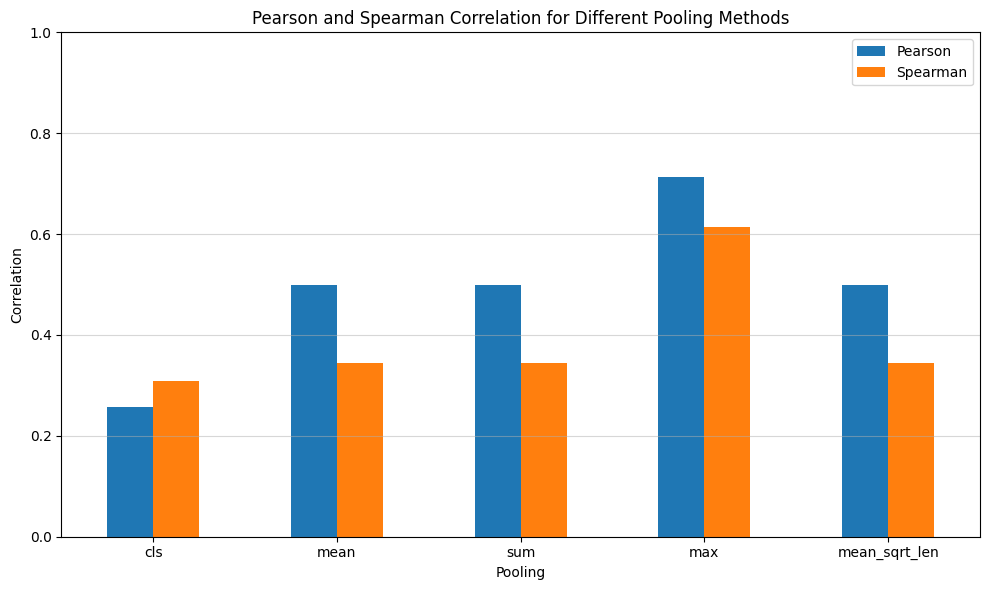

In [36]:
plot_data = []
for pooling in ['cls', 'mean', 'sum', 'max', 'mean_sqrt_len']:
    print(f"Pooling method: {pooling}")
    
    # Get the SMILES embeddings
    if pooling == 'cls':
        smiles_embeddings = torch.vstack([output.last_hidden_state[:, 0, :] for output in model_outputs])
    elif pooling == 'mean':
        smiles_embeddings = torch.vstack([output.last_hidden_state.mean(dim=1) for output in model_outputs])
    elif pooling == 'sum':
        smiles_embeddings = torch.vstack([output.last_hidden_state.sum(dim=1) for output in model_outputs])
    elif pooling == 'max':
        smiles_embeddings = torch.vstack([output.last_hidden_state.max(dim=1).values for output in model_outputs])
    elif pooling == 'mean_sqrt_len':
        seq_lengths = torch.tensor([input["input_ids"].ne(tokenizer.pad_token_id).sum().item() for input in model_inputs]).float()
        smiles_embeddings = torch.vstack([(output.last_hidden_state.sum(dim=1) / seq_length.sqrt()) for output, seq_length in zip(model_outputs, seq_lengths)])
    
    # Compute pairwise cosine similarity matrix for embeddings
    emb = smiles_embeddings.squeeze()
    if isinstance(emb, torch.Tensor):
        emb = emb.cpu().numpy()
        
    print(f"Embedding shape: {emb.shape}")
    
    emb_sim = cosine_similarity(emb)
    
    # Get the pearson and spearman correlation
    mask = np.triu_indices_from(fp_sim, k=1)
    fp_sim_flat = fp_sim[mask]
    emb_sim_flat = emb_sim[mask]
    
    pearson_corr_value, _ = pearsonr(fp_sim_flat, emb_sim_flat)
    spearman_corr_value, _ = spearmanr(fp_sim_flat, emb_sim_flat)
    
    plot_data.append({
        'Pooling': pooling,
        'Pearson': pearson_corr_value,
        'Spearman': spearman_corr_value
    })

# Bar plot of Pearson and Spearman correlations with different pooling methods
df_plot = pd.DataFrame(plot_data)
df_plot.set_index('Pooling', inplace=True)
df_plot.plot(kind='bar', figsize=(10, 6))
plt.title('Pearson and Spearman Correlation for Different Pooling Methods')
plt.ylabel('Correlation')
plt.ylim(0, 1)
# Rotate x-axis labels for better readability
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()